In [246]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import common
import numpy as np

In [247]:
q = '''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
where commit_date is not null
and version!=%s;'''
df = pd.DataFrame(sql.execute(q,(common.manualcheckup)))
df['advisory_id'].nunique()

2497

In [248]:
#not present in Maven central repository
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
where commit_date is not null
and version!=%s
and fc.advisory_id not in
(select advisory_id
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join release_info ri on fr.version = ri.version and ri.package_id=a.package_id);'''
df = pd.DataFrame(sql.execute(q,(common.manualcheckup)))
df['package_id'].nunique(), df['advisory_id'].nunique()

(75, 145)

In [249]:
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where commit_date is not null
and fr.version!='manual checkup needed'
and ri.publish_date is null;'''
df = pd.DataFrame(sql.execute(q))
df['ri.id'].nunique(), df['package_id'].nunique(), df['advisory_id'].nunique()

(357, 272, 341)

In [250]:
q = '''select advisory_id, count(distinct commit_sha)
from fix_commits
where commit_date is not null
group by advisory_id
having count(distinct commit_sha) > 1'''
df = pd.DataFrame(sql.execute(q))
len(df)

806

In [251]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))

In [252]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,
        earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
       concat(advisory_id, package_id, version) as total_release
        from
        (select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
df = pd.DataFrame(sql.execute(q))
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4


In [253]:
def get_fix_commit_date(row):
    if row['earliest_fix_commit_date'] == row['latest_fix_commit_date']:
        return row['earliest_fix_commit_date']
    else:
        if row['latest_fix_commit_date'] <= row['release_date']:
            return row['latest_fix_commit_date']
        else:
            return row['earliest_fix_commit_date']

df['fix_commit_date'] = df.apply(get_fix_commit_date, axis=1)
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1,2013-09-19 20:28:04
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8,2017-10-03 22:17:19
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8,2017-10-03 22:17:19
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2,2017-10-03 22:17:19
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8,2017-10-03 22:19:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-04 23:23:04
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5,2018-03-05 16:26:57
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22 08:42:56
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4,2019-01-22 08:42:56


In [254]:
df['fix_to_release_delay'] = (df['release_date'] - df['fix_commit_date']).dt.total_seconds()
df['fix_to_release_delay'] = round ( df['fix_to_release_delay'] / (3600 * 24))
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['publish_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['publish_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1,2013-09-19 20:28:04,28.0,131,2058,2086
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8,2017-10-03 22:17:19,6.0,40,27,33
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8,2017-10-03 22:17:19,6.0,40,27,33
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2,2017-10-03 22:17:19,6.0,40,27,33
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8,2017-10-03 22:19:25,6.0,41,27,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-04 23:23:04,0.0,0,1,1
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5,2018-03-05 16:26:57,0.0,-44,52,52
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22 08:42:56,0.0,0,0,0
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4,2019-01-22 08:42:56,0.0,0,0,0


In [255]:
df['advisory_id'].nunique(), df['fixing_release'].nunique(),  df['total_release'].nunique()

(2068, 2355, 2789)

In [256]:
total = len(df)
d2f = df[df['disclose_to_fix_delay'] > 0]
before = len(d2f)
d2f['disclose_to_fix_delay'].describe(), before/total


(count     781.000000
 mean       79.177977
 std       193.344665
 min         1.000000
 25%         2.000000
 50%         8.000000
 75%        42.000000
 max      1849.000000
 Name: disclose_to_fix_delay, dtype: float64,
 0.28002868411617066)

In [257]:
df['release_to_publish_delay'].describe()

count    2789.000000
mean      178.426318
std       464.064366
min     -1756.000000
25%         1.000000
50%        11.000000
75%       132.000000
max      4918.000000
Name: release_to_publish_delay, dtype: float64

In [258]:
wrong = df[df['fix_to_release_delay'] < 0]
wrong = wrong.sample(frac=1).reset_index(drop=True)
wrong.to_csv('delaylessthanzero.csv', index=False)
len(wrong)

149

In [259]:
temp = df[df['fix_to_publish_delay']<0]
temp = pd.merge(temp, ifcve)
temp

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay,ifcve
0,SNYK-PYTHON-AIOHTTP-40582,6,pip,Directory Traversal,M,2015-05-28,2015-05-28,2015-05-28 21:39:05,2015-05-30 19:03:25,2015-05-30 19:28:53,0.16.3,package6version0.16.3,SNYK-PYTHON-AIOHTTP-4058260.16.3,2015-05-30 19:03:25,0.0,2,-2,-2,noncve
1,SNYK-PYTHON-CHANNELS-73623,39,pip,Denial of Service (DoS),M,2018-10-16,2018-10-16,2019-01-25 22:18:51,2019-01-25 22:18:51,2019-02-01 01:36:15,2.1.7,package39version2.1.7,SNYK-PYTHON-CHANNELS-73623392.1.7,2019-01-25 22:18:51,6.0,101,-108,-101,noncve
2,SNYK-PYTHON-ANSIBLE-559099,83,pip,Information Exposure,M,2020-02-28,2020-03-02,2020-04-06 16:51:09,2020-04-09 18:42:25,2020-04-17 00:26:26,2.7.17,package83version2.7.17,SNYK-PYTHON-ANSIBLE-559099832.7.17,2020-04-09 18:42:25,7.0,41,-46,-38,cve
3,SNYK-PYTHON-ANSIBLE-559099,83,pip,Information Exposure,M,2020-02-28,2020-03-02,2020-04-06 16:51:09,2020-04-09 18:42:25,2020-04-17 00:53:48,2.8.11,package83version2.8.11,SNYK-PYTHON-ANSIBLE-559099832.8.11,2020-04-09 18:42:25,7.0,41,-46,-38,cve
4,SNYK-PYTHON-ANSIBLE-559099,83,pip,Information Exposure,M,2020-02-28,2020-03-02,2020-04-06 16:51:09,2020-04-09 18:42:25,2020-04-17 01:31:46,2.9.7,package83version2.9.7,SNYK-PYTHON-ANSIBLE-559099832.9.7,2020-04-09 18:42:25,7.0,41,-46,-38,cve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,SNYK-PYTHON-PYTHONLIBNMAP-460758,3600,pip,XML External Entity (XXE) Injection,H,2019-07-15,2019-07-15,2020-11-23 20:30:20,2020-11-25 08:22:18,2020-12-16 22:39:52,0.7.2,package3600version0.7.2,SNYK-PYTHON-PYTHONLIBNMAP-46075836000.7.2,2020-11-25 08:22:18,22.0,499,-520,-499,cve
215,SNYK-JAVA-ORGCRYPTACULAR-543303,3683,Maven,Denial of Service (DoS),H,2020-01-26,2020-01-27,2020-01-23 20:28:27,2020-02-19 14:17:27,2020-02-27 16:53:00,1.1.4,package3683version1.1.4,SNYK-JAVA-ORGCRYPTACULAR-54330336831.1.4,2020-02-19 14:17:27,8.0,24,-31,-23,cve
216,SNYK-GOLANG-GITHUBCOMARTDAREKGOUNZIP-559505,3715,Go,Arbitrary File Write via Archive Extraction (Z...,M,2020-03-05,2020-03-05,2020-03-07 21:51:43,2020-03-07 21:51:43,2020-03-08 07:21:21,1.0.0,package3715version1.0.0,SNYK-GOLANG-GITHUBCOMARTDAREKGOUNZIP-559505371...,2020-03-07 21:51:43,0.0,2,-3,-2,noncve
217,SNYK-JS-FORMIOJS-560149,3866,npm,Cross-site Scripting (XSS),M,2020-07-07,2020-07-07,2020-05-09 15:50:04,2020-10-28 17:40:32,2020-10-28 18:39:44,4.12.1-rc.19,package3866version4.12.1-rc.19,SNYK-JS-FORMIOJS-56014938664.12.1-rc.19,2020-10-28 17:40:32,0.0,113,-113,-113,noncve


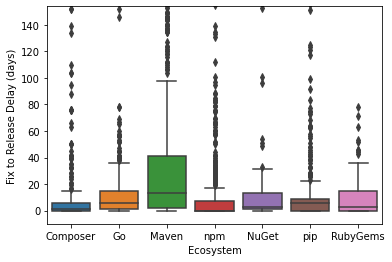

In [260]:
df= df[df['fix_to_release_delay'] >= 0]
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = df, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems'])
ax.set(ylim =(-10,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days)')
plt.savefig('fix_to_release_delay.png',bbox_inches='tight')

In [261]:
len(df[df['fix_to_release_delay']>= 500])
df['fix_to_release_delay'].describe()

count    2640.000000
mean       30.954924
std       115.271483
min         0.000000
25%         0.000000
50%         4.000000
75%        20.000000
max      2363.000000
Name: fix_to_release_delay, dtype: float64

In [262]:
npm =df[df['ecosystem']=='npm']
len(npm), len(npm[npm['fix_to_release_delay']==0])

(640, 322)

In [263]:
maven = df[df['ecosystem']=='Maven']
maven['fix_to_release_delay'].describe(), len(maven[maven['fix_to_release_delay']==0])

(count     807.000000
 mean       51.630731
 std       162.032630
 min         0.000000
 25%         2.000000
 50%        13.000000
 75%        41.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 121)

In [264]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = len(pub_before_release)

pub_before_release = str(pub_before_release) + ' (' +  str(round(pub_before_release/df['advisory_id'].nunique()*100,1)) +'%)'
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = len(pub_before_fix)
pub_before_fix = str(pub_before_fix) + ' (' + str(round(pub_before_fix/df['advisory_id'].nunique()*100,1)) +'%)'
t = ['Total', df['advisory_id'].nunique(), df['package_id'].nunique(), df['fixing_release'].nunique(), 
df['fix_to_release_delay'].median(),
df['total_release'].nunique(), pub_before_fix, pub_before_release ]
t[3] = str(t[3]) + ' (' + str(t[5]) +')'
del t[5]
t

['Total', 2001, 1342, '2240 (2640)', 4.0, '165 (8.2%)', '388 (19.4%)']

In [265]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')['fixing_release'].nunique()
total_rel = df.groupby('ecosystem')['total_release'].nunique()
fixrel = df.groupby('ecosystem')[['fix_to_release_delay']].median()

In [266]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = pub_before_release.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_release = pub_before_release.rename(columns={'advisory_id':'pub_before_release'})
pub_before_release

,pub_before_release
ecosystem,
Composer,20
Go,47
Maven,131
NuGet,5
RubyGems,10
npm,102
pip,73


In [267]:
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = pub_before_fix.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_fix = pub_before_fix.rename(columns={'advisory_id':'pub_before_fix'})
pub_before_fix

,pub_before_fix
ecosystem,
Composer,10
Go,21
Maven,27
NuGet,4
RubyGems,5
npm,62
pip,36


In [268]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, fixrel, pub_before_fix,pub_before_release, total_rel])
final = final.reset_index()
final['fixing_release'] = final['fixing_release'].map(str) +  ' (' + final['total_release'].map(str) +')'
final

,ecosystem,advisory_id,package_id,fixing_release,fix_to_release_delay,pub_before_fix,pub_before_release,total_release
0,Composer,183,93,204 (295),1.0,10,20,295
1,Go,184,150,224 (242),6.0,21,47,242
2,Maven,574,385,745 (807),13.0,27,131,807
3,NuGet,70,22,52 (75),3.0,4,5,75
4,RubyGems,113,80,121 (139),3.0,5,10,139
5,npm,553,412,586 (640),0.0,62,102,640
6,pip,324,200,308 (442),6.0,36,73,442


In [269]:

final.columns = ['ecosystem','advisory','package','releases','fix_to_release','publish_before_fix', 'publish_before_release', 'total_release']
final['temp'] = final['publish_before_release'] 
final['publish_before_release'] =  round(final['publish_before_release'] / final['advisory'] * 100, 1)
final['publish_before_release'] = final['temp'].map(str) + ' (' + final['publish_before_release'].map(str) + '%)'
final['temp'] = final['publish_before_fix'] 
final['publish_before_fix'] =  round(final['publish_before_fix'] / final['advisory'] * 100, 1)
final['publish_before_fix'] = final['temp'].map(str) + ' (' + final['publish_before_fix'].map(str) + '%)'
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp','total_release'], axis=1)
final.loc[len(final)]  = t
final

,ecosystem,advisory,package,releases,fix_to_release,publish_before_fix,publish_before_release
0,Composer,183,93,204 (295),1.0,10 (5.5%),20 (10.9%)
1,Go,184,150,224 (242),6.0,21 (11.4%),47 (25.5%)
2,Maven,574,385,745 (807),13.0,27 (4.7%),131 (22.8%)
5,npm,553,412,586 (640),0.0,62 (11.2%),102 (18.4%)
3,NuGet,70,22,52 (75),3.0,4 (5.7%),5 (7.1%)
6,pip,324,200,308 (442),6.0,36 (11.1%),73 (22.5%)
4,RubyGems,113,80,121 (139),3.0,5 (4.4%),10 (8.8%)
7,Total,2001,1342,2240 (2640),4.0,165 (8.2%),388 (19.4%)


In [270]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrlrll}
\hline
 ecosystem   &   advisory &   package & releases    &   fix\_to\_release & publish\_before\_fix   & publish\_before\_release   \\
\hline
 Composer    &        183 &        93 & 204 (295)   &                1 & 10 (5.5\%)            & 20 (10.9\%)               \\
 Go          &        184 &       150 & 224 (242)   &                6 & 21 (11.4\%)           & 47 (25.5\%)               \\
 Maven       &        574 &       385 & 745 (807)   &               13 & 27 (4.7\%)            & 131 (22.8\%)              \\
 npm         &        553 &       412 & 586 (640)   &                0 & 62 (11.2\%)           & 102 (18.4\%)              \\
 NuGet       &         70 &        22 & 52 (75)     &                3 & 4 (5.7\%)             & 5 (7.1\%)                 \\
 pip         &        324 &       200 & 308 (442)   &                6 & 36 (11.1\%)           & 73 (22.5\%)               \\
 RubyGems    &        113 &        80 & 121 (139)   &                3 & 5 

In [271]:
# q='select * from fix_commits where commit_date is not null'
# df = pd.DataFrame(sql.execute(q))
# df['auth_commit_delay'] = (df['commit_date'].dt.date - df['author_date'].dt.date).dt.days
# df['auth_commit_delay'].describe()
# print(len(df))
# df = df[df['auth_commit_delay'] > 0]
# len(df)

In [272]:
high, medium, low = df[df['severity']=='H'], df[df['severity']=='M'], df[df['severity']=='L']
high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(count    1163.000000
 mean       26.743766
 std        89.175037
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1348.000000
 mean       32.761128
 std       114.828930
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     129.000000
 mean       50.046512
 std       249.877372
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        14.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64)

In [273]:

from scipy.stats import mannwhitneyu
mannwhitneyu(high['fix_to_release_delay'],medium['fix_to_release_delay']), mannwhitneyu(high['fix_to_release_delay'],low['fix_to_release_delay']), mannwhitneyu(medium['fix_to_release_delay'],low['fix_to_release_delay']), high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(MannwhitneyuResult(statistic=739708.5, pvalue=0.0065482520451750565),
 MannwhitneyuResult(statistic=72951.0, pvalue=0.3004983938267446),
 MannwhitneyuResult(statistic=83890.0, pvalue=0.25135790074624864),
 count    1163.000000
 mean       26.743766
 std        89.175037
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1348.000000
 mean       32.761128
 std       114.828930
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     129.000000
 mean       50.046512
 std       249.877372
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        14.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64)

In [274]:
q = '''select advisory_id, package_id, ecosystem, min(release_date) as first,
       max(release_date) as last
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id
            and fcd.advisory_id in
    (select advisory_id from
(select advisory_id, count(*)
from
(select advisory_id, min(commit_date) as fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where commit_date is not null
group by advisory_id) as fcd
join
(select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id
group by advisory_id
having count(*) > 1) as sub)
group by advisory_id, package_id, ecosystem;
'''
multiple_rel = pd.DataFrame(sql.execute(q))
multiple_rel['range'] = (multiple_rel['last'].dt.date - multiple_rel['first'].dt.date).dt.days
multiple_rel['range'].describe(), len(multiple_rel[multiple_rel['range']==0])

(count     392.000000
 mean       61.946429
 std       227.415502
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         8.000000
 max      1718.000000
 Name: range, dtype: float64,
 203)

In [275]:
print(len(df), len(ifcve))
df= pd.merge(df, ifcve, on='advisory_id')
len(df)

2640 6956


2640

In [276]:
cve = df[df['ifcve']=='cve']
noncve = df[df['ifcve']=='noncve']
print(len(cve), len(noncve))

2005 635


In [277]:
cve['fix_to_release_delay'].describe(), noncve['fix_to_release_delay'].describe()

(count    2005.000000
 mean       26.752120
 std       109.322491
 min         0.000000
 25%         0.000000
 50%         4.000000
 75%        18.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 count     635.000000
 mean       44.225197
 std       131.527622
 min         0.000000
 25%         0.000000
 50%         4.000000
 75%        27.000000
 max      1341.000000
 Name: fix_to_release_delay, dtype: float64)

In [278]:
mannwhitneyu(cve['fix_to_release_delay'],noncve['fix_to_release_delay'].describe())

MannwhitneyuResult(statistic=5148.0, pvalue=0.037741962492873204)